# 在二维平面上渲染三维对象

In [1]:
try:
    import sys
    # 将项目根路径加入系统路径集合, 即可以引入相关的包
    sys.path.append("../..")
finally:
    pass

# 引入所需的包
import random
from common import Number, Vector, Vector2D, Vector3D
from common.vector import scale, length, to_radian, to_degree, to_cartesian, to_polar
from common.vector_draw import (
    Color,
    draw3d, Points3D, Arrow3D, Segment3D, Box3D,
)
from math import sqrt, sin, cos, acos, pi
from itertools import repeat


**目标:** 渲染一个简单的三维形状，称为八面体. 立方体有 `6` 个面, 所有面都是正方形; 而八面体有 `8` 个面, 所有面都是三角形. 可以把八面体看成两个互相叠加的四边金字塔

![X](../assets/octahedron.png)

如果它是一个实体, 我们就看不到对面的边了, 只能看到 `8` 个三角形面中的 `4` 个

![X](../assets/octahedron-front.png)

渲染八面体归根结底就是确定我们需要显示的 `4` 个三角形, 并进行适当的着色

## 1. 使用向量定义三维对象


八面体是一个简单的例子, 因为它只有 `6` 个角 (顶点). 我们可以为其设置简单的坐标: `(1, 0, 0)`, `(0, 1, 0)` 和 `(0, 0, 1)` 以及与它们相反的三个向量

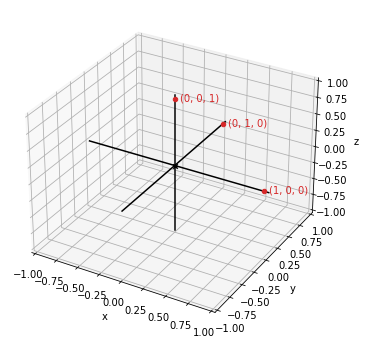

In [2]:
coords = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
]

draw3d(
    Points3D(*coords, color=Color.red),
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1),
)
